<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; How to Query, Filter, Pre-process and Visualize Spectroscopic Data



This notebook guides users on how to query science-ready spectral databases from ESO, filter the desired observations, and perform cutouts of specific spectral regions before downloading the data. It provides an example science case focusing on creating a spectral sequence for the well-known Beta Pictoris system. The presence of exo-comets is inferred from the stochastic appearances and disappearances of narrow absorption components in gas tracers such as Calcium, caused by the sublimated gas tails of the comets eclipsing our line of sight towards the star.

In addition to querying and downloading data, this notebook also demonstrates how to visualize the spectra and create animated GIFs to illustrate spectral changes over time. The GIFs provide dynamic views of the spectral data, including both cumulative and non-cumulative perspectives, enhancing the analysis of temporal variations.


**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.8.2 and Jupyter Notebook version 6.4.10. Compatibility with other versions cannot be guaranteed.

**Table of Content**

1. [**Query by Coordinates: Cone search**](#query_by_coordinate) 
2. [**Downloading the Data**](#downloading_data)
    1. [**Defining Spectral Cutouts Prior to Data Download**](#cutouts)
    2. [**Downloading the Data**](#downloading_data_process)
3. [**Retrieving and Visualizing Spectral Data**](#obtaining_spectra)
4. [**Creating Spectral Animations**](#plot_and_gif)
    1. [**Visualizing Spectra with a Static Plot**](#static_plot) 
    2. [**Animation of Cumulative Spectral Data**](#gif_cum) 
    3. [**Animation of Non-Cumulative Spectral Data**](#gif_noncum)


First, we import the necessary packages and define the [ESO Tabular Access Protocol (TAP) service](http://archive.eso.org/tap_obs) endpoint to query the reduced data. Next, we will instantiate the TAP service.


In [1]:
from pyvo.dal import tap  # Useful for interaction with online astronomical data services, allows querying databases
from astropy.coordinates import SkyCoord  # Module for handling astronomical coordinate systems

import requests # Library for making HTTP requests

import os  # Library for interacting with the operating system
import cgi  # Library for parsing headers
import pandas as pd  # Library for data manipulation and analysis
from fastparquet import write  # Useful for writing Parquet files - a columnar storage format

import coronagraph as cg  # Module for simulating the performance of coronagraphs

from astropy.io import fits as pyfits  # Module for reading and writing FITS files
import numpy as np  # Library for advanced numerical operations
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations

from matplotlib.animation import FuncAnimation, PillowWriter  # Libraries for creating animations

ESO_TAP_OBS = "http://archive.eso.org/tap_obs" # For the ESO TAP service
tapobs = tap.TAPService(ESO_TAP_OBS) # For the ESO TAP service


---
## <a id='query_by_coordinate'>1. Query by Coordinates: Cone search </a>

There are several ways to pose a query by coordinates, depending on the specific use case and the type of data you are seeking. For more details, please refer to the [How to Query for Reduced Data Notebook](https://archive.eso.org/programmatic/HOWTO/jupyter/how_to_query_for_reduced_data/ESO_How_to_query_for_reduced_data.html).

In this example, we are interested in finding datasets within 5 arcseconds of _Beta Pictoris_, making a cone search particularly useful. You can either use the object's equatorial coordinates directly or employ a name resolver like SESAME (from CDS) to retrieve them. This defines a circular search region characterized by three parameters: right ascension (RA), declination (Dec), and radius, all expressed in degrees.


In [2]:
# Defining the position via SESAME name resolver, and the search radius

target = "Beta Pictoris"
pos = SkyCoord.from_name(target) #Retrieve the coordinates of the target
sr = 5/3600. # Define the search radius in degrees, 5 arcseconds for this example

Now, to look for a given reduced dataset, we perform the cone search intersecting a circle of 5 arcseconds around our target. The query is written in ADQL (Astronomical Data Query Language).

In this query, we specify:
- **Spectral Resolving Power (`em_res_power`)**: Filtering datasets with a resolving power greater than 40000.
- **Data Product Type (`dataproduct_type`)**: Filtering for spectral data.
- **Spectral Bounds (`em_min` and `em_max`)**: Selecting spectra that cover the vacuum wavelength range expressed in meters.
- **Signal to Noise Ratio (`snr`)**: Selecting datasets with SNR greater than 300.
- **Instrument Name (`instrument_name`)**: Restricting the search to objects observed by HARPS.
- **Top 10 Objects**: Selecting the top 10 objects with the highest SNR.

For more information on the ADQL query language, refer to the [IVOA documentation](https://www.ivoa.net/documents/ObsCore/20170509/REC-ObsCore-v1.1-20170509.pdf).


In [3]:
# Cone search: looking for reduced datasets intersecting a circle of 5'' around Beta Pictoris

query = """SELECT TOP 10 *
        FROM ivoa.ObsCore
        WHERE intersects(s_region, circle('', %f, %f, %f))=1
        AND em_res_power > 40000
        AND dataproduct_type in ('spectrum')
        AND em_min < 3933.643e-10 
        AND em_max > 3933.683e-10
        AND snr > 300
        AND instrument_name in ('HARPS')
        ORDER BY SNR DESC
        """ % (pos.ra.degree , pos.dec.degree, sr)

**Send the ADQL query to the ESO TAP service and get the resulting table**


In this step, we execute the ADQL query and obtain the results from the ESO TAP service. The search query is configured to return a maximum of 10 records, so the result table (`res`) will contain up to 10 entries. For demonstration purposes, the results are displayed in a table format (`resT`). For simplicity, only the first 3 rows of the output are shown.




In [4]:
res = tapobs.search(query=query, maxrec=10000) #Maximum records to return
resT=res.to_table()
a=len(resT)
print("Num matching datasets: %d" % (a))

resT[:3]

Num matching datasets: 10


abmaglim,access_estsize,access_format,access_url,bib_reference,calib_level,dataproduct_subtype,dataproduct_type,dp_id,em_max,em_min,em_res_power,em_xel,facility_name,filter,gal_lat,gal_lon,instrument_name,last_mod_date,multi_ob,n_obs,o_calib_status,o_ucd,obs_collection,obs_creator_did,obs_creator_name,obs_id,obs_publisher_did,obs_release_date,obs_title,obstech,p3orig,pol_states,pol_xel,preview_html,proposal_id,publication_date,release_description,s_dec,s_fov,s_pixel_scale,s_ra,s_region,s_resolution,s_xel1,s_xel2,snr,strehl,t_exptime,t_max,t_min,t_resolution,t_xel,target_name
mag,kbyte,,,,,,,,m,m,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,deg,,arcsec,,,,,s,d,d,s,,
float64,int64,object,object,object,int32,object,object,object,float64,float64,float64,int64,object,object,float64,float64,object,object,object,int32,object,object,object,object,object,object,object,object,object,object,object,object,int64,object,object,object,object,float64,float64,float64,float64,object,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,object
--,5264,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2018-03-30T01:06:45.250,,2,,spectrum,ADP.2018-03-30T01:06:45.250,6.91263e-07,3.7817399999999996e-07,115000.0,313090,ESO-3.6,,-30.612309,258.363146,HARPS,2020-10-13T14:00:00.023Z,S,1,uncalibrated,,HARPS,ivo://eso.org/origfile?HARPS.2018-03-28T23:31:55.515_s1d_A_DRS_HARPS_3.8_ESOSDP.fits,"LAGRANGE, A.-M.",16,ivo://eso.org/ID?ADP.2018-03-30T01:06:45.250,2019-03-28T23:41:31.710Z,HD039060_HARPS.2018-03-28T23:31:55.515_s1d_A,ECHELLE,IDP,,--,https://archive.eso.org/dataset/ADP.2018-03-30T01:06:45.250,098.C-0739(A),2018-03-30T01:13:47Z,http://www.eso.org/rm/api/v1/public/releaseDescriptions/72,-51.06595,0.00027777,--,86.820303,POSITION J2000 86.820303 -51.06595,--,--,--,599.3,--,290.688,58205.9838681,58205.98050365,290.68848,--,HD039060
--,5264,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2019-01-22T01:15:12.551,,2,,spectrum,ADP.2019-01-22T01:15:12.551,6.9127e-07,3.78178e-07,115000.0,313093,ESO-3.6,,-30.612321,258.362396,HARPS,2020-10-13T13:59:38.160Z,S,1,uncalibrated,,HARPS,ivo://eso.org/origfile?HARPS.2019-01-20T03:44:24.669_s1d_A_DRS_HARPS_3.8_ESOSDP.fits,"DE MEDEIROS, JOSÃ© RENAN",7,ivo://eso.org/ID?ADP.2019-01-22T01:15:12.551,2020-01-21T11:25:58.927Z,HD39060_HARPS.2019-01-20T03:44:24.669_s1d_A,ECHELLE,IDP,,--,https://archive.eso.org/dataset/ADP.2019-01-22T01:15:12.551,0102.C-0584(A),2019-01-23T13:21:10Z,http://www.eso.org/rm/api/v1/public/releaseDescriptions/72,-51.06531,0.00027777,--,86.820169,POSITION J2000 86.820169 -51.06531,--,--,--,588.7,--,899.998,58503.16625773,58503.15584108,899.99856,--,HD39060
--,5264,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2017-10-14T01:06:15.813,,2,,spectrum,ADP.2017-10-14T01:06:15.813,6.91298e-07,3.7819200000000003e-07,115000.0,313107,ESO-3.6,,-30.611519,258.364826,HARPS,2020-10-13T13:59:32.410Z,S,1,uncalibrated,,HARPS,ivo://eso.org/origfile?HARPS.2017-10-13T05:36:49.265_s1d_A_DRS_HARPS_3.8_ESOSDP.fits,"LAGRANGE, A.-M.",9,ivo://eso.org/ID?ADP.2017-10-14T01:06:15.813,2018-10-13T05:46:30.813Z,HD039060_HARPS.2017-10-13T05:36:49.265_s1d_A,ECHELLE,IDP,,--,https://archive.eso.org/dataset/ADP.2017-10-14T01:06:15.813,098.C-0739(A),2017-10-14T01:13:20Z,http://www.eso.org/rm/api/v1/public/releaseDescriptions/72,-51.0673,0.00027777,--,86.821806,POSITION J2000 86.821806 -51.0673,--,--,--,474.4,--,187.858,58039.23607782,58039.23390353,187.858656,--,HD039060


---

## <a id='downloading_data'>2. Preprocessing and downloading the Data </a>

### <a id='cutouts'>2.1 Defining Spectral Cutouts Prior to Data Download</a>

In this section, we first create cutouts of specific spectral regions before downloading the data. For this analysis, we focus on selecting files that fall within a defined wavelength range (`wave_range`) to examine a region of interest, specifically around the CaII K line. To keep things organized, we will create a directory to store the files we download.


In [5]:
# Specify the parent directory; update this to match your own directory structure
parent_dir='/Users/usuario/Desktop/ESRP2024/Project/notebooks/' 

wave_range=[350,450] #range of wavelengths in nm 

# Create the target folder path based on the wavelength range to save the files
folder_path = os.path.join(parent_dir, 'TARGET_'+str(wave_range[0])+'-'+str(wave_range[1]))

# Check if the folder already exists, and create it if it does not
if os.path.exists(folder_path):
    print('The folder already exists')
else:
    os.mkdir(folder_path)
    print('Folder successfully created')

The folder already exists


### <a id='downloading_data_process'>2.2 Downloading the Data</a>

Previoulsy, we define functions to handle the retrieval and storage of FITS files from HTTP responses. 

In [6]:
def getDispositionFilename( response ): #get the filename from the header
    """Get the filename from the Content-Disposition in the response's http header"""
    contentdisposition = response.headers.get('Content-Disposition')
    if contentdisposition == None:
        return None
    value, params = cgi.parse_header(contentdisposition)
    filename = params["filename"]
    return filename

def writeFile( response, folder_path ): #write content of file on disk
    """Write on disk the retrieved file specifying a folder path"""
    if response.status_code == 200:
        # The ESO filename can be found in the response header
        filename = getDispositionFilename( response )
        # Let's write on disk the downloaded FITS spectrum using the ESO filename:
        full_path = os.path.join(folder_path, filename)
        with open(full_path, 'wb') as f:
            f.write(response.content)
        return filename 

We download FITS files from the [ESO Data Portal](https://dataportal.eso.org/dataportal_new/file/) using a specified base URL and save them to a designated folder. The process involves iterating through the query results to download and store each file on disk. 

In [16]:
#Base URL for downloading files from the ESO data portal
beg='https://dataportal.eso.org/dataportal_new/' 
notfiles=[]

for k in range(a): # Iterate through the number of matching datasets
 
    # Construct the full URL for the file download
    filebeg = f"{beg}soda/sync?ID={resT[k]['dp_id']}&PREFIX={wave_range[0]}-{wave_range[1]}&BAND={wave_range[0]}e-9+{wave_range[1]}e-9"
    response=requests.get(filebeg)
    filename = writeFile(response,folder_path) # Write the file to disk and get the filename
    
    if str(filename)!='None':
        # Print the index and filename if the file was successfully saved
        print("%i %s" % (k,filename + ' - Successfully saved.')) 
    else:
        # Print an error message if the file could not be retrieved
        print(f"{k}: {filename} - Could not get file (status: {response.status_code})")
        

0 ADP.2018-03-30T01:06:45.250_TARGET_350-450.fits - Successfully saved.
1 ADP.2019-01-22T01:15:12.551_TARGET_350-450.fits - Successfully saved.
2 ADP.2017-10-14T01:06:15.813_TARGET_350-450.fits - Successfully saved.
3 ADP.2014-09-23T11:05:49.213_TARGET_350-450.fits - Successfully saved.
4 ADP.2014-09-23T11:03:43.373_TARGET_350-450.fits - Successfully saved.
5 ADP.2014-09-23T11:03:23.373_TARGET_350-450.fits - Successfully saved.
6 ADP.2014-09-23T11:02:20.043_TARGET_350-450.fits - Successfully saved.
7 ADP.2017-10-14T01:06:15.799_TARGET_350-450.fits - Successfully saved.
8 ADP.2017-10-14T01:06:15.805_TARGET_350-450.fits - Successfully saved.
9 ADP.2014-09-23T11:02:25.960_TARGET_350-450.fits - Successfully saved.


This line checks for files that were not downloaded correctly, preventing the need to download all files again.

In [17]:
for i in range(a):  # Iterate through the number of matching datasets
    # Construct the full path to check if the file already exists  
    file_path = os.path.join(folder_path, f"{resT[i]['dp_id']}_TARGET_{wave_range[0]}-{wave_range[1]}.fits")
    if not os.path.exists(file_path): #Check if the file does not exist
        filebeg = f"{beg}soda/sync?ID={resT[i]['dp_id']}&PREFIX={wave_range[0]}-{wave_range[1]}&BAND={wave_range[0]}e-9+{wave_range[1]}e-9"
        response=requests.get(filebeg)
        filename = writeFile(response,folder_path) # Write the file to disk and get the filename 
        if str(filename)!='None':
            # Print the index and filename if the file was successfully saved
            print("%i %s" % (i,filename + ' - Successfully saved.')) 
        else:
            # Print an error message if the file could not be retrieved
            print(f"{i}: {filename} - Could not get file (status: {response.status_code})")

We check if the FITS files from the query results already exist in the specified folder on our local machine.

In [18]:
for k in range(a):
    file_path = os.path.join(folder_path, resT[i]['dp_id']+'_TARGET_'+str(wave_range[0])+'-'+str(wave_range[1])+'.fits')
    if os.path.exists(file_path):
        # Print a message if the file is already found
        print("%i %s %s" % (i, resT[i]['dp_id'], ' - Correctly founded'))
    else:  
        # Print a message if the file is not found
        print("%i %s %s" % (i, resT[i]['dp_id'], ' - Not founded'))

9 ADP.2014-09-23T11:02:25.960  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded
9 ADP.2014-09-23T11:02:25.960  - Correctly founded


---

## <a id='obtaining_spectra'>3. Retrieving and Visualizing Spectral Data</a>

**Function: Spectra_parameters**

First, we define the function `Spectra_parameters`, which calculates spectral parameters using a reference wavelength (`ref`), a resolution (`R`), and a variable range (`var`). This function constructs the wavelength array, computes the corresponding velocities, and then saves the velocity data to a CSV file.


In [19]:
c= 299792458*1.e-3 # Speed of light in km/s

def Spectra_parameters(ref,R,var):
    """Calculate spectral parameters based on reference wavelength, resolution, and variable range"""
    # Define the wavelength range around the reference
    lammin = ref-var
    lammax = ref+var
    
    # Construct the wavelength array and wavelength step size using the coronagraph module
    wl,dwl = cg.noise_routines.construct_lam(lammin,lammax,R)
    velocity=c*((wl-ref)/wl) # Calculate the velocity for each wavelength
    vel=pd.DataFrame(data=velocity,columns=['Velocity']) # Create a DataFrame with the velocities
    vel.to_csv('velocity.csv') #Save the velocity data to a CSV file
    return wl,dwl,velocity,vel,lammin,lammax

**Calculating Spectral Parameters**

We can now use the `Spectra_parameters` function to calculate spectral parameters with a given reference wavelength, resolution, and variable range.


In [20]:
ref = 3933.7 # Reference wavelength CaII K in the air expressed in Angstrom
var = 20 # Variable range around the reference wavelength in Angstrom
R = 115000 # Resolution


#Calculate spectral parameters

wl,dwl,velocity,vel,lammin,lammax=Spectra_parameters(ref,R,var)

**Processing FITS Files and Plotting Spectra**

In this section, we process the FITS files that were previously downloaded. We start by verifying the existence of each file and proceed with processing only those that are found. For each file, we open it, extract the spectral data from extension 1, normalize the flux, calculate the velocity, and generate a plot of the spectral data. The resulting plot overlays all individual spectra to facilitate comparison. The processed data is stored in a DataFrame for further analysis, while observation dates are recorded in a separate DataFrame.

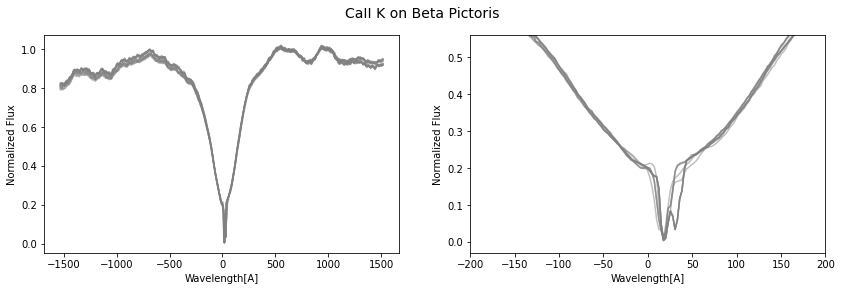

In [21]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

for i in range(a):
    # Construct the full path to the FITS file
    file_name=folder_path+'/'+resT[i]['dp_id']+'_TARGET_'+str(wave_range[0])+'-'+str(wave_range[1])+'.fits'

    # Check if the FITS file exists
    if os.path.exists(file_name): 
        hdulist = pyfits.open(file_name) # Open the FITS file
        scidata = hdulist[1].data # Bintable extension
        wave = scidata[0][0] # Wavelength data
        flux = scidata[0][1] # Flux data
        contw=[lammin,lammax]
        contf= flux[np.logical_and(wave > contw[0], wave < contw[1])] #Select fluxes within the wavelength range
        natwav=wave[np.logical_and(wave > contw[0], wave < contw[1])] # Select wavelengths within the range
        natf=contf/np.percentile(contf,95) # Normalize the flux
        flr = cg.downbin_spec(natf, natwav, wl, dlam=dwl) # Downsample the spectrum
        
        " Plot the normalized flux against wavelength "
        
        ax[0].plot(velocity,flr,c='grey',alpha=0.5)
        ax[0].set_xlabel('Wavelength[A]')
        ax[0].set_ylabel('Normalized Flux')
        ax[1].plot(velocity,flr,c='grey',alpha=0.5)
        ax[1].set_xlabel('Wavelength[A]')
        ax[1].set_ylabel('Normalized Flux')
        ax[1].set_xlim(-200,200)
        ax[1].set_ylim(-0.03,0.56)
        plt.suptitle('CaII K on Beta Pictoris', fontsize=14)
        
        # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
        if i==0:
            # If this is the first iteration (i == 0), create a new DataFrame df to store the flux data.
            df=pd.DataFrame(data=flr, columns=[resT[i]['dp_id']])
            # Create another DataFrame df2 to store the observation date (MJD) of the file.
            df2=pd.DataFrame(data=[[resT[i]['dp_id'],hdulist[0].header['MJD-OBS']]],columns=['dp_id','MJD'])
       
        
        else:
            # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
            df[resT[i]['dp_id']]=flr
            
            # Add the new observation date to the existing DataFrame df2.
            df2.loc[i]=[resT[i]['dp_id'],hdulist[0].header['MJD-OBS']]

    # Print a message if the file is not found
    else:
        print(f'File not found: {file_name}')

We save the processed data into CSV and Parquet files for future use. We then read these files back into DataFrames to ensure the data is correctly saved and can be reloaded. We also handle the velocity data separately.

In [22]:
df2.to_csv('ID-MJD.csv') # Save the df2 DataFrame to a CSV file
write('betaPicR-WST.parq', df) # Write the df DataFrame to a Parquet file
df2=pd.read_csv('ID-MJD.csv') # Read the 'ID-MJD.csv' file back into a DataFrame 

df=pd.read_parquet('betaPicR-WST.parq') # Read the parquet file back into a DataFrame 

dfvel=pd.read_csv('velocity.csv') # Read the 'velocity.csv' file into a DataFrame named dfvel
velocity=dfvel['Velocity'].values # Extract the 'Velocity' column from the dfvel DataFrame as an array

---

## <a id='plot_and_gif'>4. Creating Spectral Animations </a>

### <a id='static_plot'>4.1 Visualizing Spectra with a Static Plot</a>

To begin, we generate a static plot that displays the normalized flux as a function of velocity for all spectra in our dataset. For clarity, individual spectra are shown in grey, while the mean spectrum is highlighted in red to improve visualization and facilitate comparison.


First, we create a static plot showing the normalized flux versus velocity for all the spectra in our dataset. For clarity, we overlay individual spectra in grey and plot the mean spectrum in red to enhance visualization.


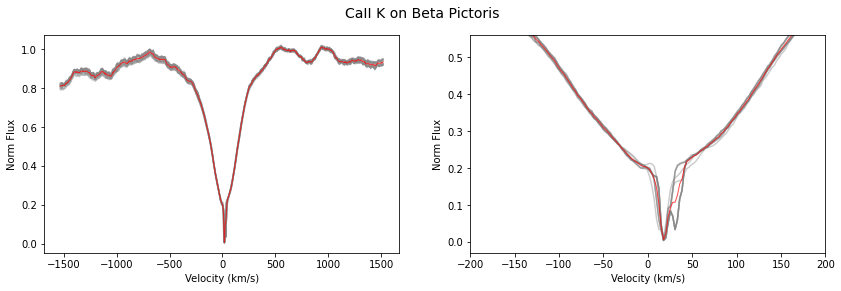

In [23]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

# Loop through each spectrum in the DataFrame df2
for i in range(df2.shape[0]):
    # Plot the normalized flux against velocity for each individual spectrum in grey with some transparency
    ax[0].plot(velocity,df[df2['dp_id'][i]].values,c='grey',alpha=0.4)
    ax[1].plot(velocity,df[df2['dp_id'][i]].values,c='grey',alpha=0.4)

# Plot the mean of all spectra in red with a slightly thicker line and reduced transparency to highlight it

ax[0].plot(velocity,df.mean(axis=1).values,lw=1,c='red',alpha=0.7)
ax[0].set_xlabel('Velocity (km/s)')
ax[0].set_ylabel('Norm Flux')

ax[1].plot(velocity,df.mean(axis=1).values,lw=1,c='red',alpha=0.7)
ax[1].set_xlabel('Velocity (km/s)')
ax[1].set_ylabel('Norm Flux')
ax[1].set_xlim(-200,200)
ax[1].set_ylim(-0.03,0.56)

plt.suptitle('CaII K on Beta Pictoris', fontsize=14)
plt.savefig(folder_path+'/Static_'+target.replace(" ", "")+'.png', dpi=300,transparent=True)

### <a id='gif_cum'>4.2 Animation of Cumulative Spectral Data</a>

We create an animated GIF that visualizes cumulative spectral data over time. This animation allows us to observe how the spectral features evolve as new data is accumulated.


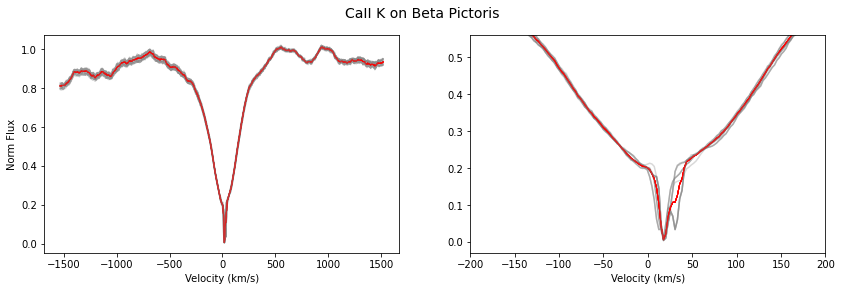

In [24]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(1,2,figsize=(14,4))
plt.suptitle('CaII K on Beta Pictoris', fontsize=14)

nframes=df.shape[1] # Determine the number of frames based on the number of columns in the DataFrame

'Cumulative Plot'

# Function to animate each frame
def animate(i):
    # Plot the mean values of the DataFrame as a red line
    line, = ax[0].plot(velocity, df.mean(axis=1).values, color = 'red', lw=1,alpha=0.7)
    line1, = ax[1].plot(velocity, df.mean(axis=1).values, color = 'red', lw=1,alpha=0.7)
    # Plot the values of the DataFrame for a specific dp_id as a grey line
    line2, = ax[0].plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=0.3)
    line3, = ax[1].plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=0.3)
    ax[0].set_xlabel('Velocity (km/s)')
    ax[0].set_ylabel('Norm Flux')
    ax[1].set_xlim(-200,200)
    ax[1].set_ylim(-0.03,0.56)
    ax[1].set_xlabel('Velocity (km/s)')
    return line, line1, line2, line3
        
# Create the animation object
ani = FuncAnimation(fig, # The figure to animate
                    animate, # The function to call for each frame
                    interval=4, # Delay between frames in milliseconds
                    blit=True,  # Optimize by only redrawing parts that have changed
                    repeat=True, # Repeat the animation indefinitely
                    frames=range(nframes), # Number of frames in the animation
                    cache_frame_data=False)    
ani.save(folder_path+'/Faster_'+target.replace(" ", "")+'.gif', dpi=300, writer=PillowWriter(fps=20))

### <a id='gif_noncum'>4.3 Animation of Non-Cumulative Spectral Data</a>

We also create an animated GIF that displays spectral data over time without accumulating it. This animation provides a dynamic view of the individual spectra as they are plotted sequentially.


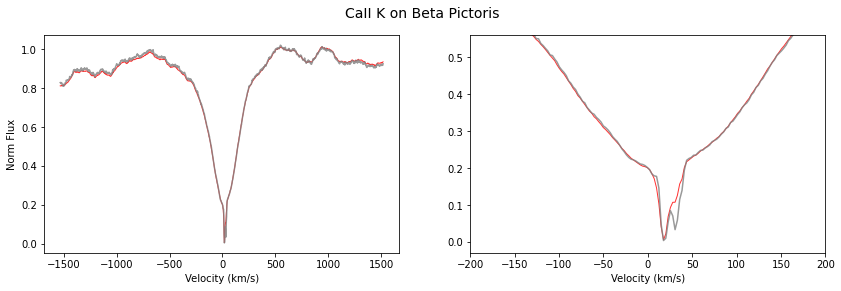

In [25]:
'Not Cumulative Plot'

fig, ax = plt.subplots(1,2,figsize=(14,4))
plt.suptitle('CaII K on Beta Pictoris', fontsize=14)

# Function to animate each frame
def animate(i):
    ax[0].clear() # Clear the previous plot to avoid overlap of lines
    ax[1].clear() # Clear the previous plot to avoid overlap of lines
    #line, = ax.plot(velocity, df.mean(axis=1).values, color = 'red', lw=1,alpha=0.7)
    #line2, = ax.plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=1)
    
    # Plot the mean values of the DataFrame as a red line
    line, = ax[0].plot(velocity, df.mean(axis=1).values, color = 'red', lw=1,alpha=0.8)
    line1, = ax[1].plot(velocity, df.mean(axis=1).values, color = 'red', lw=1,alpha=0.8)
    # Plot the values of the DataFrame for a specific dp_id as a grey line
    line2, = ax[0].plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=0.8)
    line3, = ax[1].plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=0.8)
    ax[0].set_xlabel('Velocity (km/s)')
    ax[0].set_ylabel('Norm Flux')
    ax[1].set_xlim(-200,200)
    ax[1].set_ylim(-0.03,0.56)
    ax[1].set_xlabel('Velocity (km/s)')
    return line, line2, line3, line1#, point1, point2, point3,
    #return line, line2
        
ani = FuncAnimation(fig, animate, interval=4, blit=True, repeat=True, frames=range(nframes),cache_frame_data=False)    
ani.save(folder_path+'/NonCum_'+target.replace(" ", "")+ ".gif", dpi=300, writer=PillowWriter(fps=20))